# Preprocesado de los datos de ratón
### *Sheila Santomé*
-------
En este notebook se detalla la pipeline utilizada para el preprocesamiento de los datos de ratón y está basada en el tutorial de Youtube de Sanbomics [Complete single-cell RNAseq analysis walkthrough | Advanced introduction](https://www.youtube.com/watch?v=uvyG9yLuNSE). En este caso, se analiza la muestra de Ratón 3, pero se empleará el mismo flujo de trabajo para el resto de muestras.

## Importar librerias

In [ ]:
from scipy.io import mmread
from scvi.external import SOLO
from scvi.model import SCVI

import anndata
import matplotlib.pyplot as plt
import mygene
import numpy as np
import os
import pandas as pd
import pickle
import scanpy as sc
import scvi
import seaborn as sns


c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga de los datos de entrada

En este bloque de código se realiza la **carga de los datos de entrada** necesarios para la creación del objeto **AnnData**.  En particular, se leen los tres archivos exportados desde **Seurat** en formato compatible con **Scanpy**:

- **`counts.mtx`**: matriz de conteos crudos (*raw counts*) en formato **Matrix Market (.mtx)**, que contiene la expresión génica de cada célula.  
- **`genes.txt`**: archivo con la lista de genes correspondientes a las columnas de la matriz de conteos.  
- **`cells.txt`**: archivo con los identificadores de las células correspondientes a las filas de la matriz.

El *path* de estos tres archivos se cambiará dependiendo de la muestra que se esté preprocesando.

Dado que **Scanpy** requiere que las **filas representen células** y las **columnas representen genes**, la matriz de conteos se **transpone** (`.T`) al momento de la lectura para adecuar su orientación. Posteriormente, se construye un **DataFrame disperso de pandas** mediante `pd.DataFrame.sparse.from_spmatrix`, lo que permite manejar de forma eficiente la naturaleza esparsa de los datos de expresión.

El objeto resultante, **`counts_df`**, contiene la matriz de expresión génica cruda, con las células como índices y los genes como nombres de columnas. Este objeto servirá como base para la creación del objeto **AnnData** que será utilizado en los análisis posteriores.


In [ ]:
counts_path = "./Pre-processed_data_not_cleaned/counts_mouse_3.mtx"

genes_path = "./Pre-processed_data_not_cleaned/genes.txt"

cells_path = "./Pre-processed_data_not_cleaned/cells.txt"

In [ ]:
counts = mmread(counts_path).T  
genes = pd.read_csv(genes_path, header=None)[0].tolist()
cells = pd.read_csv(cells_path, header=None)[0].tolist() 

counts_df = pd.DataFrame.sparse.from_spmatrix(counts, index=cells, columns=genes)

counts_df

,Xkr4,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Gm16041,Atp6v1h,Rb1cc1,4732440D04Rik,...,mt-Nd5,mt-Nd6,mt-Cytb,AC168977.2,CAAA01118383.1,Csprs,Vamp7,Tmlhe,CAAA01147332.1,AC149090.1
mouse_3_AAACCCAAGACCGTTT-1,0,0,0,0,0,0,0,1,1,0,...,1,0,37,0,0,0,0,0,0,0
mouse_3_AAACCCAAGCGCTTCG-1,0,0,0,0,0,0,0,0,0,0,...,3,0,32,0,0,0,0,0,0,0
mouse_3_AAACCCAAGTATCCTG-1,0,0,0,0,3,0,0,0,0,0,...,1,0,25,0,0,0,0,0,0,0
mouse_3_AAACCCAAGTCATGAA-1,0,0,0,0,0,0,0,0,0,0,...,2,0,10,0,0,0,0,0,0,0
mouse_3_AAACCCAAGTTGAAGT-1,0,0,0,0,0,0,0,0,0,0,...,3,0,39,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mouse_3_TTTGTTGGTGTCTCCT-1,0,0,1,0,0,3,0,0,0,0,...,1,0,40,0,0,0,0,0,0,0
mouse_3_TTTGTTGTCCACTTTA-1,0,0,0,1,2,0,0,1,0,0,...,3,0,39,0,1,0,0,0,0,1
mouse_3_TTTGTTGTCCATCTGC-1,0,0,1,0,1,0,0,2,0,0,...,1,0,50,0,0,0,2,0,0,0
mouse_3_TTTGTTGTCCGAGTGC-1,0,0,0,1,0,0,0,0,0,0,...,1,0,42,0,0,0,0,0,0,0


## Detección de dobletes

En este bloque se entrena un modelo para identificar células dobletes a partir de datos de expresión génica.  

- Se seleccionan los genes más relevantes con **`sc.pp.highly_variable_genes`**, manteniendo solo los que aparecen en al menos 10 células y los 2000 más variables.  
- Se prepara el objeto **AnnData** para **SCVI** usando **`scvi.model.SCVI.setup_anndata`**.  
- Se entrena el modelo probabilístico **SCVI** con la función **`vae.train()`**  
- Se utiliza **SOLO** para predecir dobletes con la función **`solo.train()`**  
- Se generan predicciones con **`solo.predict()`** y se agrega la columna binaria
- Finalmente, se ajustan los índices de las células y se calcula la diferencia entre probabilidades.

El resultado es un **DataFrame final** con las predicciones de doblete y la diferencia de probabilidades, listo para análisis posteriores.



### Filtrar Genes Altamente Variables

In [44]:
counts_data = sc.AnnData(counts_df)

In [45]:
sc.pp.filter_genes(counts_data, min_cells=20)
counts_model = counts_data.copy()

In [46]:
sc.pp.highly_variable_genes(counts_model, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

### Entrenamiento de los modelos de predicción de dobletes

In [48]:
scvi.model.SCVI.setup_anndata(counts_model)
vae = scvi.model.SCVI(counts_model)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [36:55<00:00,  5.62s/it, v_num=1, train_loss_step=839, train_loss_epoch=855]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [36:55<00:00,  5.54s/it, v_num=1, train_loss_step=839, train_loss_epoch=855]


In [49]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 153/400:  38%|███▊      | 153/400 [04:29<07:15,  1.76s/it, v_num=1, train_loss_step=0.271, train_loss_epoch=0.378]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.354. Signaling Trainer to stop.


Una vez tenemos entrenado los modelos, se pueden guardar como un objeto para no tener que entrenarlos de nuevo en caso de querer procesar los **mismos** datos.


In [15]:
vae.save("vae_model", overwrite=True)
solo.save("solo_model", overwrite=True)



En caso de querer cargarlos de nuevo se ejecuta el siguiente bloque de código.

In [ ]:

vae = SCVI.load("vae_model", adata=counts_data)

solo = SCVI.load("solo_model",adata=counts_data)


INFO     File vae_model\model.pt already downloaded                                                                


### Predicción de dobletes

In [ ]:

df = solo.predict()

df['prediction'] = solo.predict(soft = False)

df.index = df.index.map(lambda x: x[:-2])

df

c:\Python311\Lib\site-packages\torch\utils\_contextlib.py:120: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
c:\Python311\Lib\site-packages\torch\utils\_contextlib.py:120: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
mouse_3_AAACCCAAGACCGTTT,0.502143,0.497857,doublet
mouse_3_AAACCCAAGCGCTTCG,0.045918,0.954082,singlet
mouse_3_AAACCCAAGTATCCTG,0.091146,0.908854,singlet
mouse_3_AAACCCAAGTCATGAA,0.006547,0.993453,singlet
mouse_3_AAACCCAAGTTGAAGT,0.283998,0.716002,singlet
...,...,...,...
mouse_3_TTTGTTGGTGTCTCCT,0.757801,0.242199,doublet
mouse_3_TTTGTTGTCCACTTTA,0.823047,0.176953,doublet
mouse_3_TTTGTTGTCCATCTGC,0.050502,0.949498,singlet
mouse_3_TTTGTTGTCCGAGTGC,0.040007,0.959993,singlet


In [51]:
df.groupby('prediction').count()


,doublet,singlet
prediction,,
doublet,5413,5413
singlet,13044,13044


In [ ]:
df['dif'] = df.doublet - df.singlet

df

,doublet,singlet,prediction,dif
mouse_3_AAACCCAAGACCGTTT,0.502143,0.497857,doublet,0.004285
mouse_3_AAACCCAAGCGCTTCG,0.045918,0.954082,singlet,-0.908164
mouse_3_AAACCCAAGTATCCTG,0.091146,0.908854,singlet,-0.817708
mouse_3_AAACCCAAGTCATGAA,0.006547,0.993453,singlet,-0.986906
mouse_3_AAACCCAAGTTGAAGT,0.283998,0.716002,singlet,-0.432003
...,...,...,...,...
mouse_3_TTTGTTGGTGTCTCCT,0.757801,0.242199,doublet,0.515603
mouse_3_TTTGTTGTCCACTTTA,0.823047,0.176953,doublet,0.646095
mouse_3_TTTGTTGTCCATCTGC,0.050502,0.949498,singlet,-0.898996
mouse_3_TTTGTTGTCCGAGTGC,0.040007,0.959993,singlet,-0.919985


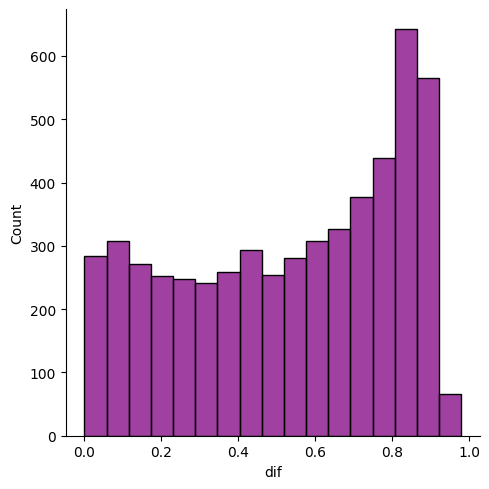

In [53]:

sns.displot(df[df.prediction == 'doublet'], x = 'dif', color= "purple")



Según el gráfico anterior, el rango entre 0.8 y 1.0 en la columna **`dif`** parece ser el más adecuado para seleccionar **doublets confiables**, ya que es donde se concentra la mayoría de los datos, lo que indica que el modelo tiene mayor certeza de que esas células son realmente doublets. Este umbral puede variar según la muestra y las características específicas de los datos analizados.


In [ ]:
dif_value = 0.8 # Cambiar dependiendo el set de datos

doublets = df[(df.prediction == 'doublet') & (df.dif > dif_value)]

doublets

,doublet,singlet,prediction,dif
mouse_3_AAACCCAGTTGTGTTG,0.939530,0.060470,doublet,0.879059
mouse_3_AAACGCTCAGGTGACA,0.913083,0.086917,doublet,0.826166
mouse_3_AAACGCTTCCGATAAC,0.945430,0.054570,doublet,0.890860
mouse_3_AAAGAACAGACGATAT,0.906851,0.093149,doublet,0.813702
mouse_3_AAAGGATTCTCATTTG,0.903817,0.096183,doublet,0.807634
...,...,...,...,...
mouse_3_TTTGACTCACTAACCA,0.929173,0.070827,doublet,0.858346
mouse_3_TTTGACTGTCACGCTG,0.904535,0.095465,doublet,0.809071
mouse_3_TTTGACTTCTTAGTTC,0.933655,0.066345,doublet,0.867309
mouse_3_TTTGGTTAGTCGTCTA,0.903840,0.096160,doublet,0.807681


A continuación se compara la columna de datos del counts_data orignal con el df que se ha generado de si es doblete o no.

In [55]:
counts_data.obs['doublet'] = counts_data.obs.index.isin(doublets.index)
counts_data.obs

,doublet
mouse_3_AAACCCAAGACCGTTT-1,False
mouse_3_AAACCCAAGCGCTTCG-1,False
mouse_3_AAACCCAAGTATCCTG-1,False
mouse_3_AAACCCAAGTCATGAA-1,False
mouse_3_AAACCCAAGTTGAAGT-1,False
...,...
mouse_3_TTTGTTGGTGTCTCCT-1,False
mouse_3_TTTGTTGTCCACTTTA-1,False
mouse_3_TTTGTTGTCCATCTGC-1,False
mouse_3_TTTGTTGTCCGAGTGC-1,False


Finalmente, se eliminan todos los dobletes del df de conteos.

In [56]:
counts_data_singlets = counts_data[~counts_data.obs.doublet]
counts_data_singlets

View of AnnData object with n_obs × n_vars = 18457 × 16142
    obs: 'doublet'
    var: 'n_cells'

------

## Adición de genes mitocondriales, ribosomales, ciclo celular y barcodes

En esta sección se agregarán varias columnas al dataset para enriquecer la información de cada célula:

- **Genes ribosomales**: se añadirá una columna que indique si cada gen pertenece a la categoría ribosomal.  
- **Genes mitocondriales**: se añadirá una columna que identifique los genes mitocondriales.  
- **Fase del ciclo celular**: se calculará y registrará la fase del ciclo celular en la que se encuentra cada célula.  
- **Condición experimental**: se añadirá una columna que indique la condición experimental de cada célula, identificando primero su **barcode** y cotejándolo con el archivo Excel que vincula barcodes con condiciones experimentales.



### Genes mitocondriales
Se buscan los genes que empiencen por mt, y se crea una columna en el que se le asigna *True* o *False* depnediendo de si el gen es mitocondrial o no.

In [57]:
counts_data_singlets.var['mt']=counts_data_singlets.var.index.str.startswith('mt-')

counts_data_singlets.var


C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_6768\4156013722.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  counts_data_singlets.var['mt']=counts_data_singlets.var.index.str.startswith('mt-')


,n_cells,mt
Xkr4,57,False
Mrpl15,5106,False
Lypla1,2414,False
Tcea1,7118,False
Rgs20,2656,False
...,...,...
Csprs,32,False
Vamp7,2491,False
Tmlhe,382,False
CAAA01147332.1,483,False


### Ribosomales

Para los genes ribosomales se descarga el set desde [el sitio web oficial de GSEA y la base de datos Molecular Signatures Database (MSigDB)](https://www.gsea-msigdb.org/gsea/index.jsp) y se cotejará con los genes del dataset con el que estemos trabajando, añadiendo una columna igual que la de los genes mitocondriales.

In [ ]:
ribo_url = "https://www.gsea-msigdb.org/gsea/msigdb/mouse/download_geneset.jsp?geneSetName=GOCC_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes[0].values

array(['Abce1', 'Abcf1', 'Apod', 'Ascc2', 'Ascc3', 'Aurkaip1', 'Calr',
       'Canx', 'Chchd1', 'Cpeb2', 'D1Pas1', 'Dap3', 'Dazl', 'Ddx3x',
       'Dhx29', 'Dmd', 'Eef1a1', 'Eef2', 'Eif2a', 'Eif2ak4', 'Eif2d',
       'Eif4g1', 'Elavl4', 'Etf1', 'Fau', 'Fubp3', 'Fxr1', 'Fxr2',
       'Gadd45gip1', 'Gcn1', 'Gm6133', 'Gm6525', 'Gspt1', 'Hbs1l',
       'Hspa14', 'Jrk', 'Larp4', 'Ltn1', 'Mcts1', 'Metap1', 'Mpv17l2',
       'Mrpl1', 'Mrpl10', 'Mrpl11', 'Mrpl12', 'Mrpl13', 'Mrpl14',
       'Mrpl15', 'Mrpl16', 'Mrpl17', 'Mrpl18', 'Mrpl19', 'Mrpl2',
       'Mrpl20', 'Mrpl21', 'Mrpl22', 'Mrpl23', 'Mrpl24', 'Mrpl27',
       'Mrpl28', 'Mrpl3', 'Mrpl30', 'Mrpl32', 'Mrpl33', 'Mrpl34',
       'Mrpl35', 'Mrpl36', 'Mrpl37', 'Mrpl38', 'Mrpl39', 'Mrpl4',
       'Mrpl40', 'Mrpl41', 'Mrpl42', 'Mrpl43', 'Mrpl44', 'Mrpl45',
       'Mrpl46', 'Mrpl47', 'Mrpl48', 'Mrpl49', 'Mrpl50', 'Mrpl51',
       'Mrpl52', 'Mrpl53', 'Mrpl54', 'Mrpl55', 'Mrpl57', 'Mrpl58',
       'Mrpl9', 'Mrps10', 'Mrps11', 'Mrps12', 'Mrps14

In [59]:
counts_data_singlets.var['ribo'] = counts_data_singlets.var_names.isin(ribo_genes[0].values)
counts_data_singlets.var

,n_cells,mt,ribo
Xkr4,57,False,False
Mrpl15,5106,False,True
Lypla1,2414,False,False
Tcea1,7118,False,False
Rgs20,2656,False,False
...,...,...,...
Csprs,32,False,False
Vamp7,2491,False,False
Tmlhe,382,False,False
CAAA01147332.1,483,False,False


### Conversión de barcodes cortos a condiciones

Primero se cruzan los archivos de **Metadata** con **Feature_reference_larry** para obtener el **barcode "largo"** de cada muestra. Esto es necesario porque en el `cell_id` el barcode tiene 16 nucleótidos, mientras que la información de las características de la célula utiliza barcodes de 26 nucleótidos.


In [ ]:
print("Leyendo archivos...")

metadata_df = pd.read_csv('./Pre-processed_data_not_cleaned/metadata_mouse_3_2.csv')

larry_df = pd.read_csv('./Feature_reference_larry.csv')

print(f"Metadatos: {metadata_df.shape}")

print(f"Larry: {larry_df.shape}")

counts_data_singlets.obs

Leyendo archivos...
Metadatos: (18457, 15)
Larry: (111, 6)


,doublet
mouse_3_AAACCCAAGACCGTTT-1,False
mouse_3_AAACCCAAGCGCTTCG-1,False
mouse_3_AAACCCAAGTATCCTG-1,False
mouse_3_AAACCCAAGTCATGAA-1,False
mouse_3_AAACCCAAGTTGAAGT-1,False
...,...
mouse_3_TTTGTTGGTGTCTCCT-1,False
mouse_3_TTTGTTGTCCACTTTA-1,False
mouse_3_TTTGTTGTCCATCTGC-1,False
mouse_3_TTTGTTGTCCGAGTGC-1,False


In [ ]:
cell_id_col = metadata_df.columns[0]

print(f"\nFiltrando por células presentes en AnnData...")

metadata_filtered = metadata_df[metadata_df[cell_id_col ].isin(counts_data_singlets.obs_names)]

print(f"Células en intersección: {len(metadata_filtered)}")



Filtrando por células presentes en AnnData...
Células en intersección: 18457


In [ ]:
print("Haciendo merge con información Larry...")

larry_map = larry_df[['name', 'sequence']].copy()

larry_map.rename(columns={'name': 'larry', 'sequence': 'barcode'}, inplace=True)


Haciendo merge con información Larry...


In [ ]:
larry_col_in_metadata = None

for col in metadata_filtered.columns:
    if any('LARRY' in str(x) for x in metadata_filtered[col].head(5)):
        larry_col_in_metadata = col
        print(f"Columna Larry identificada: {col}")
        break

if larry_col_in_metadata is None:
    print("No se encontró columna Larry. Revisando manualmente...")
    
    for col in metadata_filtered.columns:
        sample_values = metadata_filtered[col].head(3).tolist()
        print(f"Columna '{col}': {sample_values}")

    larry_col_in_metadata = 'larry' 
    print(f"Intentando con columna: {larry_col_in_metadata}")

merged_df = metadata_filtered.merge(larry_map, left_on=larry_col_in_metadata, right_on='larry', how='left')

barcode_larry = merged_df

Columna Larry identificada: larry


In [ ]:
print("Añadiendo barcode al AnnData...")


barcode_map = dict(zip(merged_df[cell_id_col], merged_df['barcode']))

counts_data_singlets.obs['barcode'] = counts_data_singlets.obs_names.map(barcode_map)

Añadiendo barcode al AnnData...


A continuación se crea un df que relaciona cada condición con cada uno de los barcadoes.

In [ ]:
barcode1 = ["TCGACCACCTGGGAGCATTGCACCTG", "GATCCAGGTGCAATGCTCCCAGGTGG"]
barcode2 = ["TCGACCTGATGCCGACAAGCAACTAG", "GATCCCTAGTTGCTTGTCGGCATCAGG"]
barcode3 = ["TCGACAGCCTGCCGGCATAAAACGTG", "GATCCACGTTTTATGCCGGCAGGCTG"]
barcode4 = ["TCGACCTTGTGATAGCAAATAACATG", "GATCCATGTTATTTGCTATCACAAGG"]
barcode6 = ["TCGACAATATGTACACACCTAACACG", "GATCCGTGTTAGGTGTGTACATATTG"]
barcode7 = ["TCGACCCCGTGTTGCCAGTAGACCCG", "GATCCGGGTCTACTGGCAACACGGGG"]
barcode8 = ["TCGACACCGTGCTATCACCGTACTAG", "GATCCTAGTACGGTGATAGCACGGTG"]
barcode9 = ["TCGACACCATGCGCACACTAGACAAG", "GATCCTTGTCTAGTGTGCGCATGGTG"]
barcode10 = ["TCGACGACGTGCGGGCAGTAGACCCG", "GATCCGGGTCTACTGCCCGCACGTCG"]
barcode12 = ["TCGACCACTTGCCGCCATGCTACGTG", "GATCCACGTAGCATGGCGGCAAGTGG"]
barcode13 = ["TCGACCAAATGTGGGCAAGTAACCAG", "GATCCTGGTTACTTGCCCACATTTGG"]
barcode14 = ["TCGACCGGCTGCGATCATCAGACCCG", "GATCCGGGTCTGATGATCGCAGCCGG"]
barcode16 = ["TCGACTAGATGATACCATCTCACGGG", "GATCCCCGTGAGATGGTATCATCTAG"]
barcode20 = ["TCGACCGCATGTTAGCAAAGCACCTG", "GATCCAGGTGCTTTGCTAACATGCGG"]


data = {
    'barcode1': barcode1,
    'barcode2': barcode2,
    'barcode3': barcode3,
    'barcode4': barcode4,
    'barcode6': barcode6,
    'barcode7': barcode7,
    'barcode8': barcode8,
    'barcode9': barcode9,
    'barcode10': barcode10,
    'barcode12': barcode12,
    'barcode13': barcode13,
    'barcode14': barcode14,
    'barcode16': barcode16,
    'barcode20': barcode20
}


df = pd.DataFrame(data).T
df.columns = ['V1', 'V2']  


df['barcode_n'] = df.index.str.replace('barcode', '')


conditions = [
    "control_1", "no_phe", "plus_phe", "no_thr", "no_trp",
    "plus_trp", "no_met", "plus_met", "no_lys", "no_his",
    "plus_his", "control_2", "plus_thr", "plus_lys"
]

df['condition'] = conditions

new_order = [0, 11, 9, 10, 8, 13, 6, 7, 1, 2, 3, 12, 4, 5]  
df = df.iloc[new_order]


df['condition'] = pd.Categorical(df['condition'], categories=df['condition'])

df = df.set_index('V2')

print(df)

barcode_conditions=df



                                                     V1 barcode_n  condition
V2                                                                          
GATCCAGGTGCAATGCTCCCAGGTGG   TCGACCACCTGGGAGCATTGCACCTG         1  control_1
GATCCGGGTCTGATGATCGCAGCCGG   TCGACCGGCTGCGATCATCAGACCCG        14  control_2
GATCCACGTAGCATGGCGGCAAGTGG   TCGACCACTTGCCGCCATGCTACGTG        12     no_his
GATCCTGGTTACTTGCCCACATTTGG   TCGACCAAATGTGGGCAAGTAACCAG        13   plus_his
GATCCGGGTCTACTGCCCGCACGTCG   TCGACGACGTGCGGGCAGTAGACCCG        10     no_lys
GATCCAGGTGCTTTGCTAACATGCGG   TCGACCGCATGTTAGCAAAGCACCTG        20   plus_lys
GATCCTAGTACGGTGATAGCACGGTG   TCGACACCGTGCTATCACCGTACTAG         8     no_met
GATCCTTGTCTAGTGTGCGCATGGTG   TCGACACCATGCGCACACTAGACAAG         9   plus_met
GATCCCTAGTTGCTTGTCGGCATCAGG  TCGACCTGATGCCGACAAGCAACTAG         2     no_phe
GATCCACGTTTTATGCCGGCAGGCTG   TCGACAGCCTGCCGGCATAAAACGTG         3   plus_phe
GATCCATGTTATTTGCTATCACAAGG   TCGACCTTGTGATAGCAAATAACATG         4     no_thr

En el siguiente bloque de código permite saber cuantas células hay de cada condición

In [ ]:
barcode_to_condition = barcode_conditions['condition'].to_dict()

counts_data_singlets.obs['condition'] = counts_data_singlets.obs['barcode'].map(barcode_to_condition)

total = counts_data_singlets.obs['condition'].value_counts()

print(total)

condition
plus_trp     10340
no_lys        1120
plus_his       608
no_thr         385
no_his         321
control_2      284
control_1      211
no_met          75
plus_met        75
plus_thr        47
no_trp          34
plus_lys        19
plus_phe         7
no_phe           0
Name: count, dtype: int64


In [ ]:
counts_data_singlets.obs

,doublet,barcode,condition
mouse_3_AAACCCAAGACCGTTT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp
mouse_3_AAACCCAAGCGCTTCG-1,False,NaN,NaN
mouse_3_AAACCCAAGTATCCTG-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp
mouse_3_AAACCCAAGTCATGAA-1,False,NaN,NaN
mouse_3_AAACCCAAGTTGAAGT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp
...,...,...,...
mouse_3_TTTGTTGGTGTCTCCT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp
mouse_3_TTTGTTGTCCACTTTA-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp
mouse_3_TTTGTTGTCCATCTGC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp
mouse_3_TTTGTTGTCCGAGTGC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp


### Añadir ciclo celular a los datos
 
Para obtener los genes del ciclo celular, se toma como referencia el contenido disponible en [este repositorio de GitHub](https://hbctraining.github.io/scRNA-seq/lessons/cell_cycle_scoring.html) y se adapta a **Python** para trabajar con genes de **ratón**.



In [ ]:

url = "https://raw.githubusercontent.com/hbc/tinyatlas/master/cell_cycle/Mus_musculus.csv"
cell_cycle_genes = pd.read_csv(url)

# Conectar con MyGene para obtener anotaciones desde Ensembl 
mg = mygene.MyGeneInfo()

# Obtener los IDs Ensembl de la tabla
ensembl_ids = cell_cycle_genes['geneID'].tolist()

# Query a MyGene para convertir Ensembl -> símbolos en ratón
mapping = mg.querymany(
    ensembl_ids,
    scopes='ensembl.gene',
    fields=['symbol', 'name', 'type_of_gene', 'genomic_pos'],
    species='mouse'
)

# Pasar el resultado a dataframe
annotations = pd.DataFrame(mapping)

cell_cycle_markers = pd.merge(
    cell_cycle_genes,
    annotations,
    left_on="geneID",
    right_on="query",
    how="left"
)

# Separar en listas de genes dependiendo de la fase célualr
s_genes = cell_cycle_markers.query("phase == 'S'")['symbol'].dropna().unique().tolist()
g2m_genes = cell_cycle_markers.query("phase == 'G2/M'")['symbol'].dropna().unique().tolist()

print("S genes:", len(s_genes))
print("G2M genes:", len(g2m_genes))

# Aplicar anotación de ciclo que ofrece el paquete de Scanpy
sc.tl.score_genes_cell_cycle(
    counts_data_singlets,
    s_genes=s_genes,
    g2m_genes=g2m_genes
)


Input sequence provided is already in string format. No operation performed


S genes: 43
G2M genes: 54


### Guardar objeto pickle 

Se guarda el objeto Anndata con todas las nuevas anotaciones.

In [ ]:
# Crear carpeta de salida si no existe
output_dir = "./pickles" 
os.makedirs(output_dir, exist_ok=True)

In [ ]:
file_path = "./pickles/counts_mouse_3_barcode.pkl"

with open(file_path, 'wb') as f:
    pickle.dump(counts_data_singlets, f)

--------------
## Cálculo de métricas de QC

En esta sección se calculan las métricas de control de calidad (QC) usando la función **`calculate_qc_metrics`** del paquete **Scanpy**, lo que permite evaluar la calidad de cada célula en términos de expresión génica.  

Posteriormente, se filtran las células con base en criterios de QC para asegurar que solo se incluyan células de buena calidad en el análisis:

- **Número de genes**: se retienen las células por debajo del percentil 98%. Esto elimina células que podrían ser multiplets o que presentan conteos excesivamente altos debido a errores técnicos.  
- **Porcentaje de genes mitocondriales**: se seleccionan células con menos del 20%. Un porcentaje alto indica células potencialmente dañadas o en apoptosis.  
- **Porcentaje de genes ribosomales**: se seleccionan células con menos del 25%. Valores altos pueden reflejar sesgos en la captura de RNA o estados celulares específicos que podrían confundir el análisis.  

Estos filtros aseguran que el dataset final contenga únicamente células de calidad confiable, reduciendo el ruido y mejorando la robustez de los análisis posteriores.


In [6]:
counts = counts_data_singlets.copy()

sc.pp.calculate_qc_metrics(counts, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

counts.obs

,doublet,barcode,condition,S_score,G2M_score,phase,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
mouse_3_AAACCCAAGACCGTTT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.112818,-0.493858,G1,2033,4528,221,4.880742,831,18.352473
mouse_3_AAACCCAAGCGCTTCG-1,False,NaN,NaN,-0.001828,-0.235902,G1,531,1060,312,29.433962,96,9.056604
mouse_3_AAACCCAAGTATCCTG-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.107801,-0.192165,G1,2210,6073,104,1.712498,1405,23.135189
mouse_3_AAACCCAAGTCATGAA-1,False,NaN,NaN,-0.023567,-0.041504,G1,538,811,87,10.727497,84,10.357583
mouse_3_AAACCCAAGTTGAAGT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.071906,-0.280756,G1,833,1626,432,26.568266,171,10.516605
...,...,...,...,...,...,...,...,...,...,...,...,...
mouse_3_TTTGTTGGTGTCTCCT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.354243,-0.112600,S,3260,9379,250,2.665529,2011,21.441518
mouse_3_TTTGTTGTCCACTTTA-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.275803,-0.659687,S,3691,11623,346,2.976856,2258,19.426998
mouse_3_TTTGTTGTCCATCTGC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.437544,-0.134096,S,2900,9356,282,3.014109,2037,21.772125
mouse_3_TTTGTTGTCCGAGTGC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.010811,-0.135771,G1,1506,3125,242,7.744000,556,17.792000


In [7]:
counts.var.sort_values('n_cells_by_counts')

,n_cells,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Gm48708,20,False,False,20,0.001084,99.891640,20
1700028K03Rik,20,False,False,20,0.001084,99.891640,20
Gm37214,20,False,False,20,0.001138,99.891640,21
Ifnab,20,False,False,20,0.001084,99.891640,20
Gm43137,20,False,False,20,0.001084,99.891640,20
...,...,...,...,...,...,...,...
mt-Co2,18395,True,False,18395,43.322425,0.335916,799602
S100a6,18404,False,False,18404,73.102238,0.287154,1349248
mt-Co3,18414,True,False,18414,41.620198,0.232974,768184
mt-Atp6,18421,True,False,18421,57.176735,0.195048,1055311


A mayores, pueden filtrarse celulas que no tengan un mínimo de 200 genes. 

In [8]:
counts.obs.sort_values('n_genes_by_counts')
sc.pp.filter_cells(counts, min_genes=200)

Se utiliza la función **`sc.pl.violin`** de **Scanpy** para visualizar la distribución de varias métricas de control de calidad en las células, incluyendo **`n_genes_by_counts`**, **`total_counts`**, **`pct_counts_mt`** y **`pct_counts_ribo`**. Estos gráficos permiten identificar células con valores atípicos, como conteos extremadamente altos o bajos, o un porcentaje elevado de genes mitocondriales o ribosomales, lo que facilita su filtrado antes de continuar con el análisis.


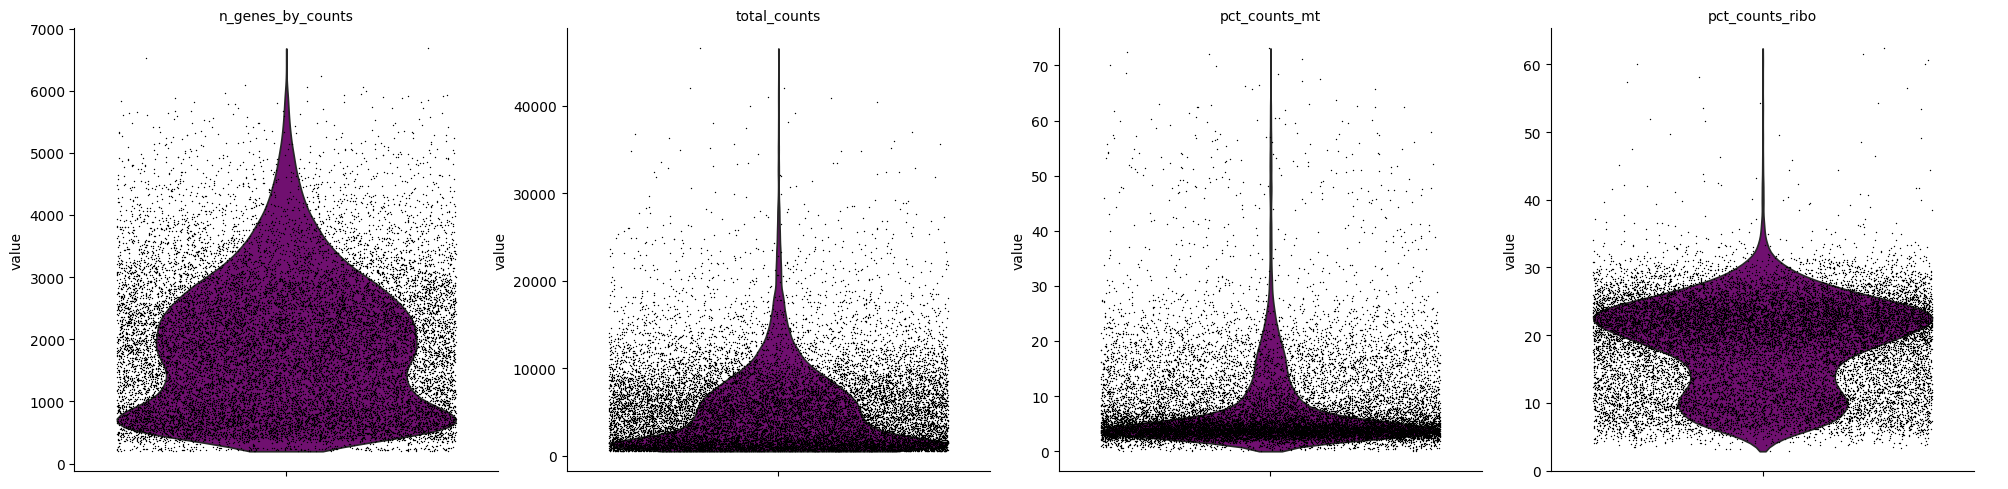

In [9]:
sc.pl.violin(counts, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True, color="purple")

Se genera un gráfico de dispersión con **`sc.pl.scatter`** de **Scanpy**, mostrando la relación entre el **número total de conteos** (`total_counts`) y el **número de genes detectados** (`n_genes_by_counts`) en cada célula, y coloreando los puntos según el **porcentaje de genes mitocondriales** (`pct_counts_mt`). Este gráfico permite visualizar la distribución de las células y detectar **outliers**, es decir, aquellas con conteos muy altos o bajos o un porcentaje elevado de genes mitocondriales, que podrían indicar células dañadas o de baja calidad, facilitando su eliminación antes de continuar con el análisis.


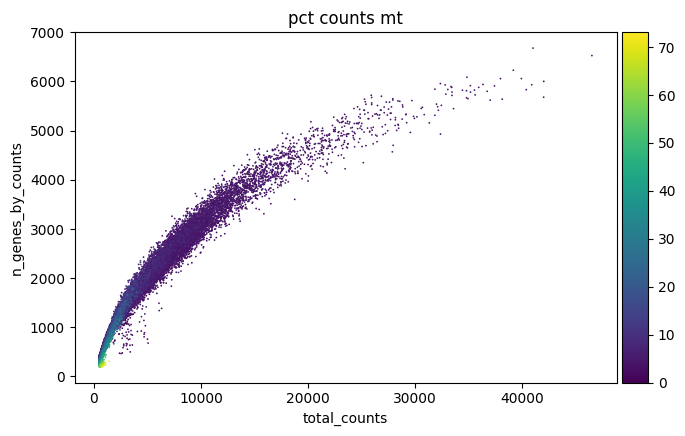

In [10]:
sc.pl.scatter(counts, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


A continuación, se filtran las células utilizando los criterios de QC definidos al inicio de este bloque. Estos valores pueden ajustarse según la interpretación de los gráficos, adaptándose a la distribución observada en los datos para eliminar de manera óptima los outliers.

### Upper Limit

In [11]:
upper_lim = np.quantile(counts.obs.n_genes_by_counts.values, .98)
counts = counts[counts.obs.n_genes_by_counts < upper_lim ]
counts.obs


,doublet,barcode,condition,S_score,G2M_score,phase,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
mouse_3_AAACCCAAGACCGTTT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.112818,-0.493858,G1,2033,4528,221,4.880742,831,18.352473,2033
mouse_3_AAACCCAAGCGCTTCG-1,False,NaN,NaN,-0.001828,-0.235902,G1,531,1060,312,29.433962,96,9.056604,531
mouse_3_AAACCCAAGTATCCTG-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.107801,-0.192165,G1,2210,6073,104,1.712498,1405,23.135189,2210
mouse_3_AAACCCAAGTCATGAA-1,False,NaN,NaN,-0.023567,-0.041504,G1,538,811,87,10.727497,84,10.357583,538
mouse_3_AAACCCAAGTTGAAGT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.071906,-0.280756,G1,833,1626,432,26.568266,171,10.516605,833
...,...,...,...,...,...,...,...,...,...,...,...,...,...
mouse_3_TTTGTTGGTGTCTCCT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.354243,-0.112600,S,3260,9379,250,2.665529,2011,21.441518,3260
mouse_3_TTTGTTGTCCACTTTA-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.275803,-0.659687,S,3691,11623,346,2.976856,2258,19.426998,3691
mouse_3_TTTGTTGTCCATCTGC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.437544,-0.134096,S,2900,9356,282,3.014109,2037,21.772125,2900
mouse_3_TTTGTTGTCCGAGTGC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.010811,-0.135771,G1,1506,3125,242,7.744000,556,17.792000,1506


### Porcentaje mitocondrial

In [12]:
counts = counts[counts.obs.pct_counts_mt < 20]
counts.obs

,doublet,barcode,condition,S_score,G2M_score,phase,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
mouse_3_AAACCCAAGACCGTTT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.112818,-0.493858,G1,2033,4528,221,4.880742,831,18.352473,2033
mouse_3_AAACCCAAGTATCCTG-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.107801,-0.192165,G1,2210,6073,104,1.712498,1405,23.135189,2210
mouse_3_AAACCCAAGTCATGAA-1,False,NaN,NaN,-0.023567,-0.041504,G1,538,811,87,10.727497,84,10.357583,538
mouse_3_AAACCCACAAGCACCC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.078829,-0.270798,S,3037,8922,216,2.420982,2003,22.450123,3037
mouse_3_AAACCCACACATATGC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.183246,0.175972,G2M,3859,13361,333,2.492328,2836,21.225956,3859
...,...,...,...,...,...,...,...,...,...,...,...,...,...
mouse_3_TTTGTTGGTGTCTCCT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.354243,-0.112600,S,3260,9379,250,2.665529,2011,21.441518,3260
mouse_3_TTTGTTGTCCACTTTA-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.275803,-0.659687,S,3691,11623,346,2.976856,2258,19.426998,3691
mouse_3_TTTGTTGTCCATCTGC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.437544,-0.134096,S,2900,9356,282,3.014109,2037,21.772125,2900
mouse_3_TTTGTTGTCCGAGTGC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.010811,-0.135771,G1,1506,3125,242,7.744000,556,17.792000,1506


### Porcentaje ribosómico

In [13]:
counts = counts[counts.obs.pct_counts_ribo< 30]
counts.obs

,doublet,barcode,condition,S_score,G2M_score,phase,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
mouse_3_AAACCCAAGACCGTTT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.112818,-0.493858,G1,2033,4528,221,4.880742,831,18.352473,2033
mouse_3_AAACCCAAGTATCCTG-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.107801,-0.192165,G1,2210,6073,104,1.712498,1405,23.135189,2210
mouse_3_AAACCCAAGTCATGAA-1,False,NaN,NaN,-0.023567,-0.041504,G1,538,811,87,10.727497,84,10.357583,538
mouse_3_AAACCCACAAGCACCC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.078829,-0.270798,S,3037,8922,216,2.420982,2003,22.450123,3037
mouse_3_AAACCCACACATATGC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.183246,0.175972,G2M,3859,13361,333,2.492328,2836,21.225956,3859
...,...,...,...,...,...,...,...,...,...,...,...,...,...
mouse_3_TTTGTTGGTGTCTCCT-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.354243,-0.112600,S,3260,9379,250,2.665529,2011,21.441518,3260
mouse_3_TTTGTTGTCCACTTTA-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.275803,-0.659687,S,3691,11623,346,2.976856,2258,19.426998,3691
mouse_3_TTTGTTGTCCATCTGC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,0.437544,-0.134096,S,2900,9356,282,3.014109,2037,21.772125,2900
mouse_3_TTTGTTGTCCGAGTGC-1,False,GATCCGGGTCTACTGGCAACACGGGG,plus_trp,-0.010811,-0.135771,G1,1506,3125,242,7.744000,556,17.792000,1506


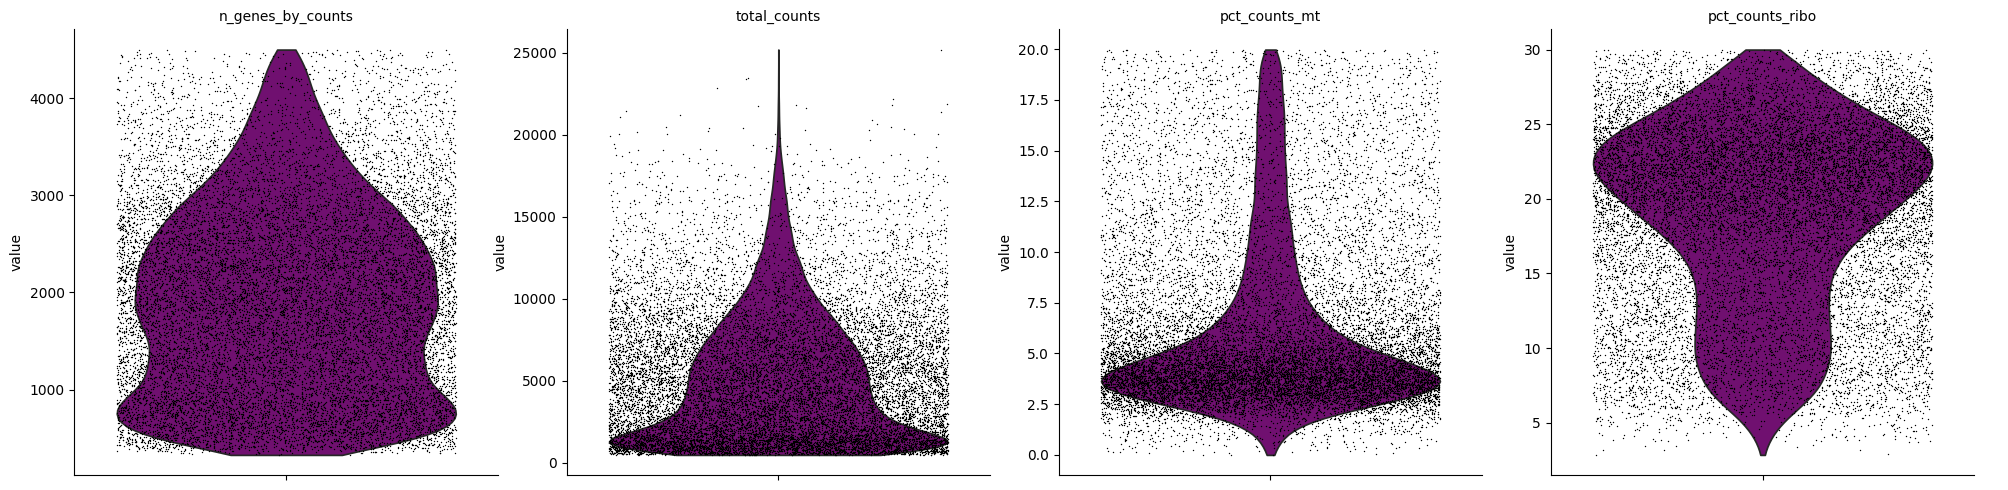

In [14]:
sc.pl.violin(counts, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True, color="purple")

### Guardar archivo 

In [ ]:
with open('./pickles/counts_mouse_3_barcode_qcmetrics.pkl', 'wb') as f:
    pickle.dump(counts, f)